# Patient Journey Analysis and Visualization

This notebook aims to analyze patient movement data to understand the relationship between the number of transfers and the length of stay (LOS). We will also combine various datasets to create a complete patient journey analysis and visualize patient flow using Sankey diagrams.

## 1. Imports

In [2]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go  # For Sankey diagrams
from datetime import timedelta
from collections import defaultdict

# Visualization for missing data
import missingno as msno

# Scikit-learn imports (if needed)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## 2. Data Loading

We define the file paths to the datasets and load them into pandas DataFrames.



In [3]:
# Modify this to direct to the data stored locally
file_paths = {
    'edstays': "../ED/edstays.csv",
    'admissions': "../HOSP/admissions.csv",
    'transfers': "../HOSP/transfers.csv",
    'diagnosis': "../ED/diagnosis.csv",
    'triage': "../ED/triage.csv",
    'vitalsigns': "../ED/vitalsign.csv",
    'medrecon': "../ED/medrecon.csv",
    'patients': "../HOSP/patients.csv"
}


## 3. Analyzing Transfers and Length of Stay

### 3.1 Load and Preprocess Transfers Data

In [38]:
# Load Transfers Data
transfers_df = pd.read_csv(file_paths['transfers'])

# Convert datetime columns
transfers_df['intime'] = pd.to_datetime(transfers_df['intime'])
transfers_df['outtime'] = pd.to_datetime(transfers_df['outtime'])

# Calculate Length of Stay (LOS) in hours
transfers_df['los'] = (transfers_df['outtime'] - transfers_df['intime']).dt.total_seconds() / 3600

transfers_df

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime,los
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00,4.216667
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27,17.857500
2,10000032,22595853.0,36904543,discharge,UNKNOWN,2180-05-07 17:21:27,NaT,NaN
3,10000032,22841357.0,34100253,discharge,UNKNOWN,2180-06-27 18:49:12,NaT,NaN
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12,21.303333
...,...,...,...,...,...,...,...,...
2413584,19999914,NaN,32002659,ED,Emergency Department,2158-12-24 11:41:00,2158-12-24 11:56:00,0.250000
2413585,19999987,23865745.0,30249304,transfer,Neurology,2145-11-04 21:29:30,2145-11-11 13:00:47,159.521389
2413586,19999987,23865745.0,34731548,ED,Emergency Department,2145-11-02 19:28:00,2145-11-02 22:59:00,3.516667
2413587,19999987,23865745.0,36195440,admit,Trauma SICU (TSICU),2145-11-02 22:59:00,2145-11-04 21:29:30,46.508333


### 3.2 Analyze Patient Movement

We define a function to summarize patient movement data.

In [39]:
def analyze_patient_movement(df):
    """
    Summarizes patient movement data by subject_id and hadm_id.
    """
    patient_stays = df.groupby(['subject_id', 'hadm_id'])
    
    movement_summary = patient_stays.agg(
        num_transfers=('eventtype', 'count'),
        total_los=('los', 'sum'),
        num_units=('careunit', 'nunique')
    )
    
    movement_summary['avg_time_per_unit'] = movement_summary['total_los'] / movement_summary['num_units']
    
    return movement_summary

# Generate Movement Summary
movement_summary = analyze_patient_movement(transfers_df)

# Display Summary Statistics
print("Summary of patient movement:")
print(movement_summary.describe())


Summary of patient movement:
       num_transfers      total_los      num_units  avg_time_per_unit
count  546025.000000  546025.000000  546025.000000      546025.000000
mean        3.671268     118.920617       3.207408          36.912997
std         1.466438     188.122255       0.866075          59.157673
min         1.000000       0.000000       1.000000           0.000000
25%         3.000000      31.754722       3.000000          10.990833
50%         3.000000      71.919722       3.000000          23.114259
75%         4.000000     138.994167       3.000000          42.691111
max        34.000000   52894.029444      14.000000       17631.343148


### 3.3 Average Time Spent in Each Unit


In [41]:
# Calculate Average Time Spent in Each Unit
unit_time = transfers_df.groupby('careunit')['los'].agg(['mean', 'median', 'count']).sort_values('count', ascending=False)

print("\nAverage time spent in each unit:")
unit_time



Average time spent in each unit:


,mean,median,count
careunit,,,
Emergency Department,7.038319,5.339722,784399
Medicine,69.081396,43.529167,191843
Emergency Department Observation,4.742284,0.445556,101341
Discharge Lounge,10.827407,12.519167,71241
Med/Surg,66.872366,42.955000,56905
Medicine/Cardiology,58.669751,36.877778,53891
Neurology,64.780727,42.077917,49746
Transplant,82.474241,47.977778,37903
Hematology/Oncology,101.543491,55.179167,37354


### 3.4 Visualize Patient Flow


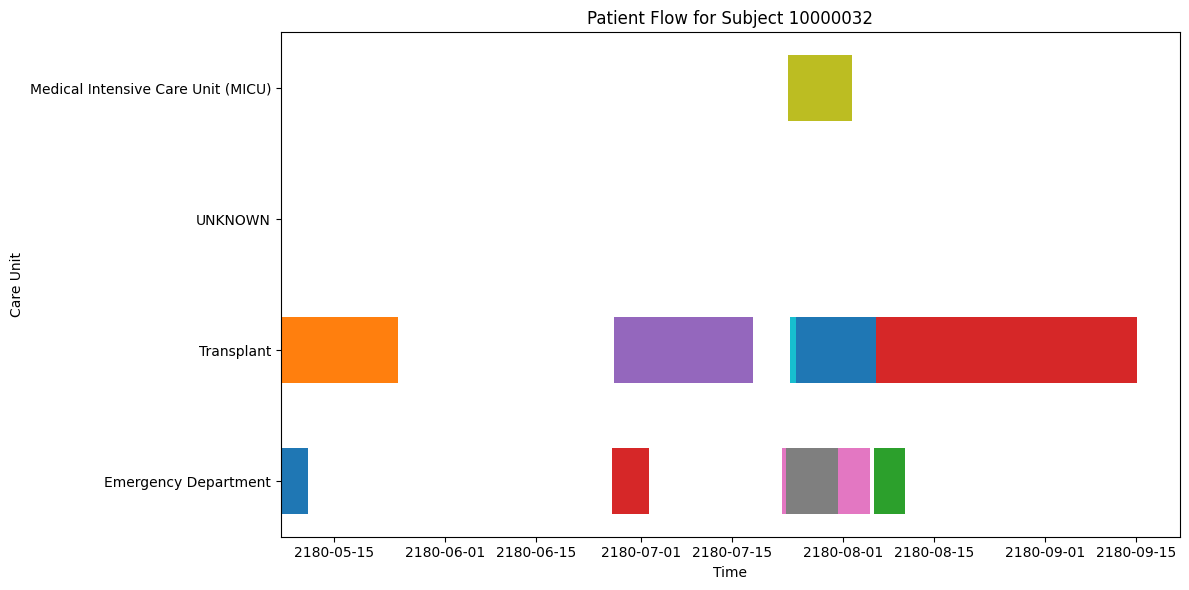

In [45]:
def plot_patient_flow(df, patient_id):
    """
    Plots the flow of a patient through different care units over time.
    """
    patient_data = df[df['subject_id'] == patient_id].sort_values('intime')
    
    plt.figure(figsize=(12, 6))
    
    for _, row in patient_data.iterrows():
        plt.barh(row['careunit'], row['los'], left=row['intime'], height=0.5)
    
    plt.title(f'Patient Flow for Subject {patient_id}')
    plt.xlabel('Time')
    plt.ylabel('Care Unit')
    plt.tight_layout()
    plt.show()

# Example: Plot Flow for the First Patient
first_patient = transfers_df['subject_id'].iloc[1]
plot_patient_flow(transfers_df, first_patient)


### 3.5 Analyze Common Patient Pathways


In [47]:
def get_patient_pathway(group):
    """
    Constructs a pathway string for a patient's care units.
    """
    return ' -> '.join(group['careunit'])

patient_pathways = transfers_df.sort_values('intime').groupby('subject_id').apply(get_patient_pathway)
common_pathways = patient_pathways.value_counts().head(10)

print("\nMost common patient pathways:")
common_pathways



Most common patient pathways:


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_9923/895010755.py:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Emergency Department                                                                            112290
Emergency Department -> Emergency Department                                                     18295
Emergency Department -> Emergency Department Observation -> UNKNOWN                              16179
Emergency Department -> Medicine -> UNKNOWN                                                       7686
Emergency Department -> Emergency Department -> Emergency Department                              5611
Emergency Department -> Neurology -> UNKNOWN                                                      2744
Emergency Department -> Med/Surg -> UNKNOWN                                                       2363
Emergency Department -> Med/Surg/Trauma -> UNKNOWN                                                2316
Emergency Department -> Emergency Department -> Emergency Department -> Emergency Department      2254
Emergency Department -> Surgery/Trauma -> UNKNOWN                        

### 3.6 Visualize Distributions


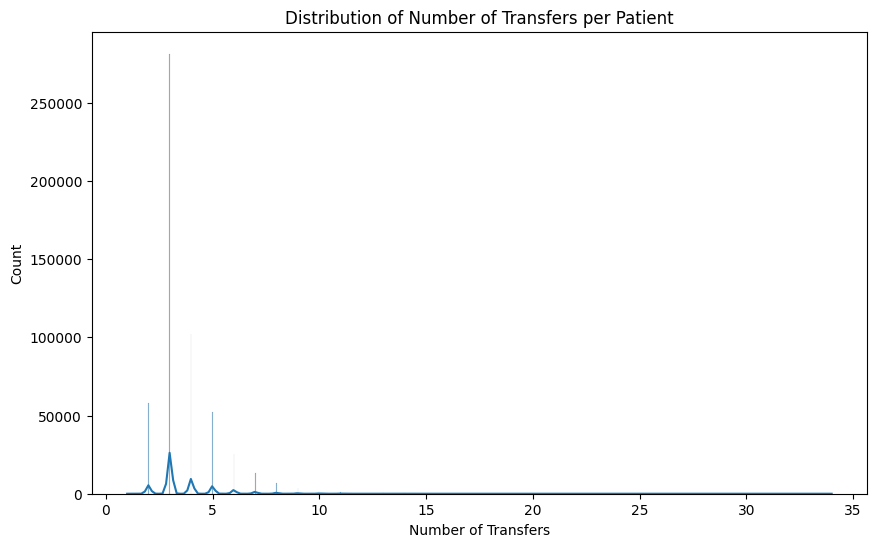

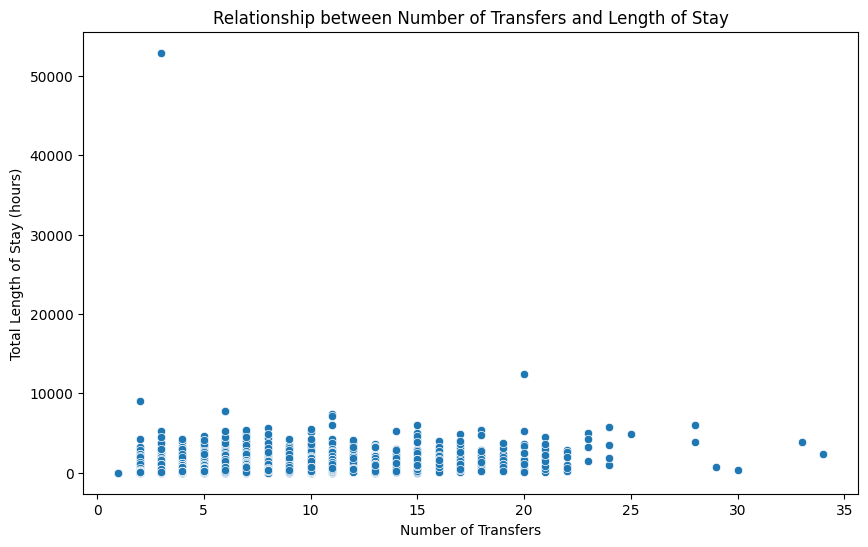

In [48]:
# Distribution of Number of Transfers
plt.figure(figsize=(10, 6))
sns.histplot(movement_summary['num_transfers'], kde=True)
plt.title('Distribution of Number of Transfers per Patient')
plt.xlabel('Number of Transfers')
plt.ylabel('Count')
plt.show()

# Relationship Between Number of Transfers and Length of Stay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_transfers', y='total_los', data=movement_summary)
plt.title('Relationship between Number of Transfers and Length of Stay')
plt.xlabel('Number of Transfers')
plt.ylabel('Total Length of Stay (hours)')
plt.show()


## 4. Complete Patient Journey Analysis

Let's combine edstays, triage, and diagnosis with hospital admissions and transfers data.



In [ ]:
# Load datasets
edstays_df = pd.read_csv(file_paths['edstays'])
triage_df = pd.read_csv(file_paths['triage'])
diagnosis_df = pd.read_csv(file_paths['diagnosis'])
admissions_df = pd.read_csv(file_paths['admissions'])
transfers_df = pd.read_csv(file_paths['transfers'])


In [18]:
# Load datasets
edstays_df = pd.read_csv(file_paths['edstays'])
triage_df = pd.read_csv(file_paths['triage'])
diagnosis_df = pd.read_csv(file_paths['diagnosis'])
admissions_df = pd.read_csv(file_paths['admissions'])
transfers_df = pd.read_csv(file_paths['transfers'])

# Preprocess and merge datasets
def preprocess_and_merge_data(edstays_df, triage_df, diagnosis_df, admissions_df, transfers_df):
    # Convert datetime columns
    datetime_columns = ['intime', 'outtime', 'admittime', 'dischtime']
    for df in [edstays_df, triage_df, admissions_df, transfers_df]:
        for col in datetime_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col])
    
    # Merge datasets
    merged_df = edstays_df.merge(triage_df, on=['subject_id', 'stay_id'], how='left')
    merged_df = merged_df.merge(admissions_df, on=['subject_id', 'hadm_id'], how='left')
    merged_df = merged_df.merge(transfers_df, on=['subject_id', 'hadm_id'], how='left')
    
    return merged_df

merged_df = preprocess_and_merge_data(edstays_df, triage_df, diagnosis_df, admissions_df, transfers_df)
merged_df.head()


,subject_id,hadm_id,stay_id,intime_x,outtime_x,gender,race_x,arrival_transport,disposition,temperature,...,marital_status,race_y,edregtime,edouttime,hospital_expire_flag,transfer_id,eventtype,careunit,intime_y,outtime_y
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,98.4,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0.0,33258284.0,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,98.4,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0.0,35223874.0,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,98.4,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0.0,36904543.0,discharge,UNKNOWN,2180-05-07 17:21:27,NaT
3,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,98.9,...,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0.0,34100253.0,discharge,UNKNOWN,2180-06-27 18:49:12,NaT
4,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,98.9,...,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0.0,34703856.0,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12


: 

### 4.2 Calculate Lengths of Stay


In [10]:
# Calculate ED length of stay
merged_df['ed_los'] = (merged_df['outtime_x'] - merged_df['intime_x']).dt.total_seconds() / 3600
merged_df['hos_los'] = (merged_df['dischtime'] - merged_df['admittime']).dt.total_seconds() / 3600


,subject_id,hadm_id,stay_id,intime_x,outtime_x,gender,race_x,arrival_transport,disposition,temperature,...,marital_status,race_y,edregtime,edouttime,hospital_expire_flag,transfer_id,eventtype,careunit,intime_y,outtime_y
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,98.4,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0.0,33258284.0,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,98.4,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0.0,35223874.0,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,98.4,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0.0,36904543.0,discharge,UNKNOWN,2180-05-07 17:21:27,NaT
3,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,98.4,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0.0,33258284.0,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
4,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,98.4,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0.0,35223874.0,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27


### 4.2 Calculate Lengths of Stay


In [50]:
# Calculate ED length of stay
merged_df['ed_los'] = (merged_df['outtime_x'] - merged_df['intime_x']).dt.total_seconds() / 3600
merged_df['hos_los'] = (merged_df['dischtime'] - merged_df['admittime']).dt.total_seconds() / 3600


### 4.3 Analyze Triage Impact on Patient Journey


Impact of Triage Acuity on Patient Journey:
          ed_los     hos_los  patient_count  icu_admission_rate
acuity                                                         
1.0     5.900290  178.690494         227408            0.108475
2.0     8.214395  128.156901        1341157            0.028801
3.0     6.684983  102.676588        2701280            0.004164
4.0     4.018233   50.917485         338820            0.000100
5.0     3.186539   45.487559          17822            0.000056


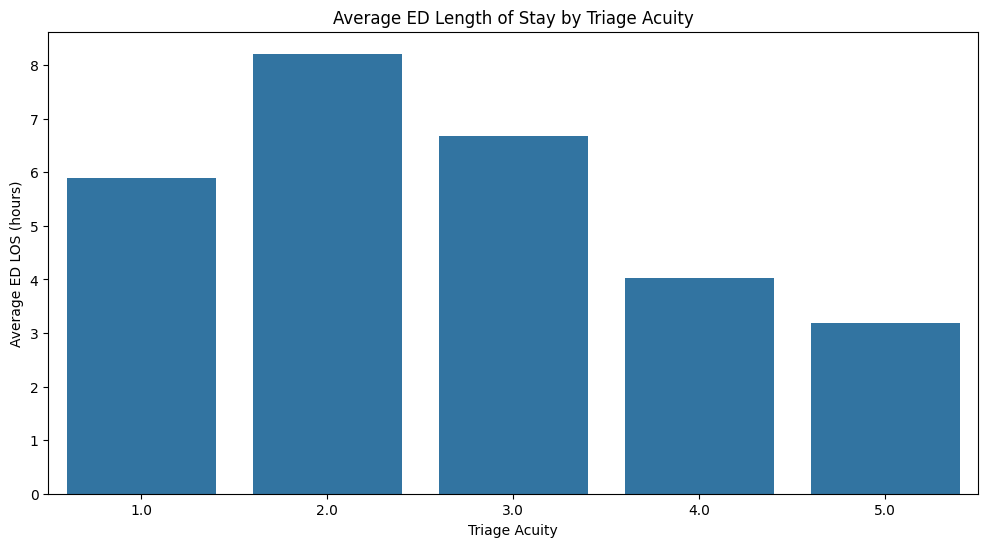

In [51]:
def analyze_triage_impact(df):
    triage_impact = df.groupby('acuity').agg({
        'ed_los': 'mean',
        'hos_los': 'mean',
        'subject_id': 'count'
    }).rename(columns={'subject_id': 'patient_count'})
    
    triage_impact['icu_admission_rate'] = df[df['careunit'].str.contains('ICU', na=False)].groupby('acuity')['subject_id'].count() / triage_impact['patient_count']
    
    return triage_impact

triage_impact = analyze_triage_impact(merged_df)
print("Impact of Triage Acuity on Patient Journey:")
print(triage_impact)

# Visualize triage impact
plt.figure(figsize=(12, 6))
sns.barplot(x=triage_impact.index, y='ed_los', data=triage_impact)
plt.title('Average ED Length of Stay by Triage Acuity')
plt.xlabel('Triage Acuity')
plt.ylabel('Average ED LOS (hours)')
plt.show()


### 4.4 Engineer Care Unit Sequence and Create Sankey Diagrams


We will first create a simplified Sankey diagram with fewer nodes (Admission, ED, Ward, Discharge) to understand the primary patient flow. Then, we will create a more detailed Sankey diagram.


### 4.4.1 Engineer Care Unit Sequence for Simplified Diagram


In [52]:
def categorize_care_unit_simple(unit):
    if pd.isna(unit) or unit == 'UNKNOWN' or unit == 'Unknown':
        return 'Unknown'
    elif 'Emergency' in unit:
        return 'ED'
    elif 'ICU' in unit or 'Intensive Care' in unit:
        return 'Ward'  # For simplicity, include ICU in Ward
    else:
        return 'Ward'

def engineer_care_unit_sequence_simple(df):
    df = df.sort_values(['stay_id', 'intime_x'])
    df['careunit_category_simple'] = df['careunit'].apply(categorize_care_unit_simple)
    df['prev_careunit_simple'] = df.groupby('stay_id')['careunit_category_simple'].shift(1)
    df['next_careunit_simple'] = df.groupby('stay_id')['careunit_category_simple'].shift(-1)
    df['prev_careunit_simple'] = df.groupby('stay_id')['prev_careunit_simple'].fillna('Admission')
    return df

# Apply the simple categorization
merged_df = engineer_care_unit_sequence_simple(merged_df)


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_9923/3402472303.py:16: FutureWarning:

SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead



### 4.4.2 Create Simplified Sankey Diagram


In [53]:
def create_sankey_diagram_simple(df):
    stages = ['Admission', 'ED', 'Ward', 'Discharge']
    color_scheme = {'Admission': 'yellow', 'ED': 'orange', 'Ward': 'lightgreen', 'Discharge': 'black'}
    
    # Calculate flows
    flows = {}
    for source in stages[:-1]:
        for target in stages[1:]:
            if source == target:
                continue
            if source == 'Admission':
                count = df[(df['prev_careunit_simple'] == 'Admission') & (df['careunit_category_simple'] == target)]['stay_id'].nunique()
            elif target == 'Discharge':
                count = df[(df['careunit_category_simple'] == source) & (df['next_careunit_simple'].isna())]['stay_id'].nunique()
            else:
                count = df[(df['careunit_category_simple'] == source) & (df['next_careunit_simple'] == target)]['stay_id'].nunique()
            if count > 0:
                flows[(source, target)] = count
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=stages,
            color=[color_scheme[stage] for stage in stages]
        ),
        link=dict(
            source=[stages.index(s) for s, _ in flows.keys()],
            target=[stages.index(t) for _, t in flows.keys()],
            value=list(flows.values()),
            customdata=list(flows.values()),
            hovertemplate='%{source.label} → %{target.label}<br>Patients: %{value}<extra></extra>'
        )
    )])

    fig.update_layout(
        title_text="Simplified Patient Flow Sankey Diagram",
        font_size=10,
        autosize=False,
        width=800,
        height=600
    )
    fig.show()

# Create the simplified Sankey diagram
create_sankey_diagram_simple(merged_df)


### 4.4.3 Engineer Care Unit Sequence for Detailed Diagram


In [62]:
def categorize_care_unit_detailed(unit):
    if pd.isna(unit) or unit == 'UNKNOWN' or unit == 'Unknown':
        return 'Unknown'
    elif 'Emergency' in unit:
        return 'ED'
    elif 'ICU' in unit or 'Intensive Care' in unit:
        return 'ICU'
    elif 'Intermediate' in unit or 'Stepdown' in unit:
        return 'Intermediate Care'
    elif 'Obstetrics' in unit or 'Labor & Delivery' in unit:
        return 'Obstetrics'
    elif 'Cardiology' in unit or 'Cardiac' in unit:
        return 'Cardiology'
    elif 'Surgery' in unit or 'PACU' in unit:
        return 'Surgery'
    elif 'Neuro' in unit:
        return 'Neurology'
    elif 'Psychiatry' in unit:
        return 'Psychiatry'
    elif 'Oncology' in unit:
        return 'Oncology'
    else:
        return 'General Ward'

def engineer_care_unit_sequence_detailed(df):
    df = df.sort_values(['stay_id', 'intime_x'])
    df['careunit_category_detailed'] = df['careunit'].apply(categorize_care_unit_detailed)
    df['prev_careunit_detailed'] = df.groupby('stay_id')['careunit_category_detailed'].shift(1)
    df['next_careunit_detailed'] = df.groupby('stay_id')['careunit_category_detailed'].shift(-1)
    df['prev_careunit_detailed'] = df.groupby('stay_id')['prev_careunit_detailed'].fillna('Admission')
    return df

# Apply the detailed categorization
merged_df = engineer_care_unit_sequence_detailed(merged_df)


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_9923/2046589412.py:30: FutureWarning:

SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead



### 4.4.4 Create Detailed Sankey Diagram


In [68]:

def calculate_flows(df, stages, prev_col, curr_col, next_col):
    flows = {}
    for source in stages:
        for target in stages:
            if source == target:
                continue
            if source == 'Admission':
                count = df[(df[prev_col] == 'Admission') & (df[curr_col] == target)]['stay_id'].nunique()
            elif target == 'Discharge':
                count = df[(df[curr_col] == source) & (df[next_col].isna())]['stay_id'].nunique()
            else:
                count = df[(df[curr_col] == source) & (df[next_col] == target)]['stay_id'].nunique()
            if count > 0:
                flows[(source, target)] = count
    return flows

def calculate_node_sizes(flows, stages):
    node_sizes = defaultdict(int)
    for (source, target), value in flows.items():
        node_sizes[source] += value
        node_sizes[target] += value
    node_sizes_list = [node_sizes.get(stage, 0) for stage in stages]
    return node_sizes_list

def create_detailed_sankey_diagram(df):
    # Define stages and colors
    stages = ['Admission', 'ED', 'General Ward', 'ICU', 'Intermediate Care', 'Surgery', 'Cardiology', 'Neurology', 'Oncology', 'Obstetrics', 'Psychiatry', 'Unknown', 'Discharge']
    color_scheme = {'Admission': 'yellow', 'ED': 'orange', 'General Ward': 'lightgreen', 
                    'ICU': 'red', 'Intermediate Care': 'pink', 'Surgery': 'purple', 
                    'Cardiology': 'lightblue', 'Neurology': 'blue', 'Oncology': 'green', 
                    'Obstetrics': 'cyan', 'Psychiatry': 'magenta', 'Unknown': 'gray', 
                    'Discharge': 'black'}

    flows = calculate_flows(df, stages, 'prev_careunit_detailed', 'careunit_category_detailed', 'next_careunit_detailed')
    node_sizes = calculate_node_sizes(flows, stages)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=stages,
            color=[color_scheme[stage] for stage in stages],
            customdata=node_sizes,
            hovertemplate='%{label}<br>Patients: %{customdata}<extra></extra>'
        ),
        link=dict(
            source=[stages.index(s) for s, _ in flows.keys()],
            target=[stages.index(t) for _, t in flows.keys()],
            value=list(flows.values()),
            customdata=list(flows.values()),
            hovertemplate='%{source.label} → %{target.label}<br>Patients: %{value}<extra></extra>'
        )
    )])

    fig.update_layout(
        title_text="Detailed Patient Flow Sankey Diagram",
        font_size=10,
        autosize=False,
        width=1200,
        height=800
    )
    fig.show()

# Create the detailed Sankey diagram
create_detailed_sankey_diagram(merged_df)


In [69]:
def map_to_grouped_care_unit(unit):
    if unit in ['ICU', 'Intermediate Care']:
        return 'Critical Care'
    elif unit in ['Surgery', 'Cardiology', 'Neurology', 'Oncology', 'Obstetrics', 'Psychiatry']:
        return 'Specialty Care'
    elif unit == 'General Ward':
        return 'General Ward'
    elif unit == 'ED':
        return 'ED'
    elif unit == 'Unknown':
        return 'Unknown'
    else:
        return unit  # Keep as is or categorize as needed

def engineer_care_unit_sequence_grouped(df):
    df = df.sort_values(['stay_id', 'intime_x'])
    df['careunit_category_grouped'] = df['careunit_category_detailed'].apply(map_to_grouped_care_unit)
    df['prev_careunit_grouped'] = df.groupby('stay_id')['careunit_category_grouped'].shift(1)
    df['next_careunit_grouped'] = df.groupby('stay_id')['careunit_category_grouped'].shift(-1)
    df['prev_careunit_grouped'] = df.groupby('stay_id')['prev_careunit_grouped'].fillna('Admission')
    return df

# Apply the grouping function
merged_df = engineer_care_unit_sequence_grouped(merged_df)


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_9923/1027767545.py:20: FutureWarning:

SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead



In [71]:
def create_grouped_sankey_diagram(df):
    # Define grouped stages and colors
    stages = ['Admission', 'ED', 'Critical Care', 'Specialty Care', 'General Ward', 'Unknown', 'Discharge']
    color_scheme = {
        'Admission': 'yellow',
        'ED': 'orange',
        'Critical Care': 'red',
        'Specialty Care': 'blue',
        'General Ward': 'lightgreen',
        'Unknown': 'gray',
        'Discharge': 'black'
    }
    
    # Calculate flows using the grouped categories
    flows = calculate_flows(df, stages, 'prev_careunit_grouped', 'careunit_category_grouped', 'next_careunit_grouped')
    node_sizes = calculate_node_sizes(flows, stages)
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=stages,
            color=[color_scheme[stage] for stage in stages],
            customdata=node_sizes,
            hovertemplate='%{label}<br>Patients: %{customdata}<extra></extra>'
        ),
        link=dict(
            source=[stages.index(s) for s, _ in flows.keys()],
            target=[stages.index(t) for _, t in flows.keys()],
            value=list(flows.values()),
            customdata=list(flows.values()),
            hovertemplate='%{source.label} → %{target.label}<br>Patients: %{value}<extra></extra>'
        )
    )])

    fig.update_layout(
        title_text="Grouped Patient Flow Sankey Diagram",
        font_size=10,
        autosize=False,
        width=1000,
        height=600
    )
    fig.show()

create_grouped_sankey_diagram(merged_df)

: 